### Workflow to Validate NISAR L2Permafrost Displacement Requirement

**Code authored by:** Andrew Johnson, Simon Zwieback, Franz Meyer, Jie Chen</br>
2024

<div class="alert alert-warning">
UPDATE THIS Both the initial setup (<b>Prep A</b> section) and download of the data (<b>Prep B</b> section) should be run at the start of the notebook. And all subsequent sections NEED to be run in order.
</div>

<hr/>

Define CalVal Site

In [1]:
# Choose a site and track direction
# Available permafrost displacement validation sites: 
#        NorthSlopeEastD102      : North Slope of Alaska including Dalton highway, Sentinel-1 path (track) 102. The
#                                  field validation sites are located in this frame.

site='NorthSlopeEastD102'
year=2023

### Table of Contents


[**Prep A. Environment Setup**](#permafrost_prep_a)

[**Prep B. Data Staging**](#permafrost_prep_b)

[**1. Generation of Interferogram stack**](#permafrost_infgs)

[**2. Generation of time series from interferograms**](#permafrost_mintpy)
- [2.1 Set up MintPy configuration file](#permafrost_mintpy_config)
- [2.2 Load data into MintPy](#permafrost_mintpy_load)
- [2.3 Validate/Modify interferogram network](#permafrost_mintpy_validate)
- [2.4 Reference interferograms to common lat/lon](#permafrost_mintpy_reference)
- [2.5 Invert for SBAS line-of-site timeseries](#permafrost_mintpy_invert)

[**3. Optional Corrections**](#permafrost_correct)
- [3.1 Troposphere correction](#permafrost_corect_troposphere)
- [3.2 Phase deramping](#permafrost_correct_phase)
- [3.3 Topographic residual correction](#permafrost_correct_topography)

[**4. Validation method A: InSAR-only struction functions**](#permafrost_insar_validate)
- [4.1 Use structure functions to identify pixel pairs](#permafrost_insar_structure)
- [4.2 Evaluate displacements of pairs with respect to requirement](#permafrost_insar_evaluate)

[**5. Validation method B: Comparison to ground truth displacements**](#permafrost_field_validate)
- [5.1 Load field data](#permafrost_field_data)
- [5.2 Prepare InSAR for field comparison](#permafrost_field_prepare)
- [5.3 Re-run MintPy with field reference points](#permafrost_reference_point)
- [5.4 Evaluate displacements with respect to requirement](#permafrost_field_evaluate)

<a id='permaforst_prep_a'></a>
## Prep A. Environment Setup

In [2]:

#do imports
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import os
from pathlib import Path
from solid_utils import permafrost_utils as pu
# from mintpy import view, tsview, plot_network, plot_transection, plot_coherence_matrix
from mintpy import plot_network,view
from mintpy.utils import readfile
import subprocess
import h5py
from datetime import datetime
from solid_utils.sampling import load_geo_utm, samp_pair,load_geo_utm


In [3]:
################# Set Directories ##########################################
print('\nCurrent directory:',os.getcwd())

#Base directory for working on projects
if 'base_dir' not in locals():
    base_dir = Path.cwd()
    
# work_dir = Path.cwd()/'work'/'permafrost_ouputs'/site/str(year)
work_dir = base_dir/'work'/'permafrost_ouputs'/site/str(year)
print("Work directory:", work_dir)
work_dir.mkdir(parents=True, exist_ok=True)

# Change to Workdir   
os.chdir(work_dir)
       
hyp3_dir = work_dir/'products'               #aka gunwdir
hyp3_dir.mkdir(parents=True, exist_ok=True)
print("   Hyp3  dir:", hyp3_dir) 
    
mintpy_dir = work_dir/'MintPy' 
mintpy_dir.mkdir(parents=True, exist_ok=True)
print("   MintPy  dir:", mintpy_dir)
############################################################################
### List of CalVal Sites:
'''
Set NISAR calval sites:
    NorthSlopeEastD102      : North Slope of Alaska including Dalton highway, Sentinel-1 descending path (track) 102. 
                            : The field validation sites are located in this frame.
    NorthSlopeWestD44       : Western area of the North Slope of Alaska, Sentinel-1 descending path (track) 44.
    NorthwestTerritoriesA78 : North east of Yellowknife, Sentinel-1 ascending path (track) 78.


Hyp3 & MintPy parameters:
    calval_location    : name
    region_identifier  : WTK string with latlon point for identifying image in Hyp3
    subset_region      : subset analysis area, in UTM. Given in '[ymin:ymax,xmin:xmax]' or 'none'
    download_start_date : download start date as YYYMMDD  
    download_end_date   : download end date as YYYMMDD
    mintpy_ref_loc     : reference point for use in mintpy in UTM Y,X order. Projection must be that of the Hyp3 images.
    tempBaseMax        : maximum number of days, don't use interferograms longer than this value 
    ifgExcludeList     : default is not to exclude any interferograms
    maskWater          : interior locations don't need to mask water
    sentinel_path      : asfPath number for identifying image. Also called track.
    sentinel_frame     : asfFrame number for identifying image
'''
sites = {
    ##########  NORTH SLOPE EAST (DALTON/TOOLIK) ##############
    'NorthSlopeEastD102' : {'calval_location' : 'NorthSlopeEastD102',
            'region_identifier' : 'POINT(-149.37 69.09)',
            'subset_region' : '[7620213:7686754, 641941:679925]',            
            'download_start_date' : '20230525',
            'download_end_date'   : '20230910',
            'mintpy_ref_loc'      : '7651392, 666923',
            'tempBaseMax' : '36',
            'ifgExcludeList' : 'auto',
            'maskWater' : 'True',
            'sentinel_direction' : 'DESCENDING',
            'sentinel_path' : '102',
            'sentinel_frame' : '362'},
    'NorthSlopeWestD44' : {'calval_location' : 'NorthSlopeWestD44',
            'region_identifier' : 'POINT(-160.25 68.82)',
            'subset_region' : 'none',
            'download_start_date' : '20230525',
            'download_end_date'   : '20230910',
            'mintpy_ref_loc' : '7684081, 437118',
            'tempBaseMax' : '36',
            'ifgExcludeList' : 'auto',
            'maskWater' : 'True',
            'sentinel_direction' : 'DESCENDING',
            'sentinel_path' : '44',
            'sentinel_frame' : '362'},
    'NorthwestTerritoriesA78' : {'calval_location' : 'NorthwestTerritoriesA78',
            'region_identifier' : 'POINT(-111.35 63.20)',
            'subset_region' : 'none',
            'download_start_date' : '20230525',
            'download_end_date'   : '20230910',
            'mintpy_ref_loc'      : '6980804, 522414',
            'tempBaseMax' : '36',
            'ifgExcludeList' : 'auto',
            'maskWater' : 'True',
            'sentinel_direction' : 'ASCENDING',
            'sentinel_path' : '78',
            'sentinel_frame' : '204'},    
}

permafrost_available_sites = ['NorthSlopeEastD102','NorthSlopeWestD44','NorthwestTerritoriesA78']

if site not in permafrost_available_sites:
    msg = '\nSelected site not available! Please select one of the following sites:: \n{}'.format(permafrost_available_sites)
    raise Exception(msg)
else:
    print('\nSelected site: {}'.format(site))
    for key, value in sites[site].items():
        print('   '+ key, ' : ', value)


Current directory: /home/jovyan/NISAR_cal
Work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
   Hyp3  dir: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/products
   MintPy  dir: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy

Selected site: NorthSlopeEastD102
   calval_location  :  NorthSlopeEastD102
   region_identifier  :  POINT(-149.37 69.09)
   subset_region  :  [7620213:7686754, 641941:679925]
   download_start_date  :  20230525
   download_end_date  :  20230910
   mintpy_ref_loc  :  7651392, 666923
   tempBaseMax  :  36
   ifgExcludeList  :  auto
   maskWater  :  True
   sentinel_direction  :  DESCENDING
   sentinel_path  :  102
   sentinel_frame  :  362


<a id='permafrost_prep_b'></a>
## Prep B: Data staging

Author's note: processed Sentinel-1 interferograms may be staged in a S3 bucket in the future. They are not staged yet however, so ```Use_Staged_Data``` must remain false, and the interferograms must be obtained from Hyp3. 

See [Section 1](#permafrost_infgs) for details on creating and downloading this data.

In [4]:
# option to control the use of pre-staged data; [False/True]
Use_Staged_Data = False

######### DO NOT CHANGE LINES BELOW ########

if Use_Staged_Data:
    #No data included in staging yet.
    print('This section has yet to be added.\nNo data has been staged yet.')
else:
    #Data must be processed from Hyp3
    print('Not using staged data. You must use Hyp3 to produce the interferograms.')
    print('Field validation data is currently included in the git repo at the moment,\nbut will be moved to the cal/val database')

Not using staged data. You must use Hyp3 to produce the interferograms.
Field validation data is currently included in the git repo at the moment,
but will be moved to the cal/val database


<a id='permafrost_infgs'></a>
# 1. Generation of interferogram stack

The NISAR project will provide sets of fully coregistered ascending and descending unwrapped L2 interferograms (aka InSAR “stacks”) over regions of interest listed in the NISAR Solid Earth calval document. Prior to the launch of NISAR, we use interferograms generated by the Hybrid Pluggable Processing Pipeline (Hyp3) at the Alaska Satellite Facility (ASF) from Sentinel-1 SAR data. Hyp3 interfergram generation uses GAMMA and identifies overlapping Sentinel-1 bursts, and coregisters them using an iterative offset polynomial method and an Enhanced Spectral Diversity algorithm. Information about the Hyp3 inferferogram generation [can be found here](#https://hyp3-docs.asf.alaska.edu/guides/insar_product_guide/).

Use the [Generating Hyp3 Interferograms](./Generate_Hyp3_Interferograms.ipynb) notebook to produce and download this data. We create interferogram stacks to cover a 96 day summer time period over on permafrost terrain to measure displacement when the surface is snow-free and traditionally experiencing subsidence.

<a id='permafrost_mintpy'></a>
# 2. Generation of time series from interferograms

InSAR time series (i.e. the unfiltered displacement of each pixel vs. time) will be estimated from a processed InSAR stack using a variant of the small baseline subset (SBAS) approach. For this step, we use a time series inversion method of the Miami InSAR Time-series software in Python (MintPy) with 12 and 24 day interferogram pairs.

Note: this code is currently set up to run on MintPy version 1.5.1.

<a id='permafrost_mintpy_config'></a>
## 2.1 Set Up MintPy configuration file

Mintpy will be configured to use the hyp3 processor. A function is defined here, to allow for future subsetting and adjustment of reference pixel location.

In [5]:
def writenumpyconfig(config_file,data_dir,reflalo = None, subset = None):
    """Write a mintpy config file.
    config_file: file name to write to
    data_dir: directory of .tif files
    reflalo (optional): 'y,x' of reference point in tif proj
    subset (optional): '[ymin:ymax,xmin:xmax]' in tif proj
    
    Note: hyp3 provides images in a utm projection, so lalo here refers to y,x in map coords"""
    
    cfgtext = f"""
    mintpy.load.processor        = hyp3
    ##---------interferogram datasets:
    mintpy.load.unwFile          = {data_dir}/*/*_unw_phase_clipped.tif
    mintpy.load.corFile          = {data_dir}/*/*_corr_clipped.tif
    ##---------geometry datasets:
    mintpy.load.demFile          = {data_dir}/*/*_dem_clipped.tif
    mintpy.load.incAngleFile     = {data_dir}/*/*_lv_theta_clipped.tif
    mintpy.load.azAngleFile      = {data_dir}/*/*_lv_phi_clipped.tif
    mintpy.load.waterMaskFile    = {data_dir}/*/*_water_mask_clipped.tif"""

    if reflalo:
            cfgtext+=f"""    
    mintpy.reference.lalo         = {reflalo}"""  #should be 'y,x' in map coords
    
    if not subset:
        subset = 'no'
    cfgtext+=f"""
    mintpy.subset.lalo            = {subset}""" #should be '[ymin:ymax,xmin:xmax]' in map coords

    mintpy_config = config_file
    mintpy_config.write_text(cfgtext)

config_file = mintpy_dir/f"{sites[site]['calval_location']}_{str(year)}.cfg"
writenumpyconfig(config_file,hyp3_dir,reflalo=sites[site]['mintpy_ref_loc'])

<a id='permafrost_mintpy_load'></a>
## 2.2 Load Data into MintPy

The output of this step is an "inputs" directory in 'calval_directory/calval_location/MintPy/' containing two HDF5 files:

* ifgramStack.h5: This file contains 6 dataset cubes (e.g. unwrapped phase, coherence, connected components etc.) and multiple metadata
* geometryGeo.h5: This file contains geometrical datasets (e.g., incidence/azimuth angle, masks, etc.)


In [8]:
#Delete any existing water masks. This is done in case later sections of this notebook
#have already been run, as their masks will only include a subset of the region.
watermask = work_dir/'waterMask.h5'
if watermask.exists():
    watermask.unlink()

command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep load_data'
process = subprocess.run(command, shell=True)
print('Mintpy input files:')
[x for x in os.listdir('inputs') if x.endswith('.h5')]

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-22 18:20:12.105258--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['load_data']
Remaining steps: ['modify_network', 'reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
read custom template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/

['ifgramStack.h5', 'geometryGeo.h5', 'ERA5.h5']

<a id='permafrost_mintpy_validate'></a>
## 2.3 Validate/Modify Interferogram Network


In [45]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep modify_network'
process = subprocess.run(command, shell=True)

# Currently I cannot get plot_network to work properly (suggestions welcome).
# There seems to be a class object called inps which is supposed to contain metadata 
# and numerous plotting options, but I do not know how to create this object.
# plot_network.plot_network(inps)

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-22 19:19:27.365999--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['modify_network']
Remaining steps: ['reference_point', 'quick_overview', 'correct_unwrap_error', 'invert_network', 'correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
read custom template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaseline

<a id='permafrost_mintpy_reference'></a>
## 2.4 Reference interferograms to common Lat/Lon

Note: The printed ```REF_LAT``` and ```REF_LON``` from this step will be the UTM y and x coordinates, respectively. ```REF_X``` and ```REF_Y``` are the j and i (column and row) indices of the reference.

In [14]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep reference_point'
process = subprocess.run(command, stdout=subprocess.PIPE, stderr=subprocess.STDOUT, text=True, shell=True)
os.system('info.py inputs/ifgramStack.h5 | egrep "REF_"');

  REF_LAT                      7651400.0
  REF_LON                      666920.0
  REF_X                        3308
  REF_Y                        1435


<a id='permafrost_mintpy_invert'></a>
## 2.5 Invert for SBAS Line-of-Sight Timeseries

Run the network inversion to generate the timeseries file.

Note: If run in OpenScienceLab, this step takes approximately 30 minutes to complete.

In [15]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep invert_network'
process = subprocess.run(command, shell=True)

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-22 00:44:21.552387--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['invert_network']
Remaining steps: ['correct_LOD', 'correct_SET', 'correct_troposphere', 'deramp', 'correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
read custom template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaselineApp.cfg
read default template file: /home/jovyan/NISAR_cal/work/permafrost_oupu

<a id='permafrost_correct'></a>
# 3. Optional corrections

Mintpy provides functionality for a number of standard corrections which might improve the accuracy of the timeseries inversion or displacement results. Several corrections are shown here:

* Troposphere correction </br>
* Deramping </br>
* Topographic residual correction

None of these corrections are currently applied in the analysis presented in this notebook, but the code here can easily be modified to add this functionality if desired.

<a id='permafrost_correct_troposphere'></a>
## 3.1 Trophosphere correction

Atmospheric effects, especially moisture, can cause phase delays in the measured satellite signal. ERA5 reanalysis products provide information about atmospheric moisture and can be used to estimate the tropospheric phase delays. Performing this correction requires obtaining the ERA5 reanalysis products separately.

In [92]:
do_tropo_correction = False
########################################################################
'''
REFERENCE : https://github.com/insarlab/pyaps#2-account-setup-for-era5
Read Section 2 for ERA5 [link above] to create an account on the CDS website.
'''

if do_tropo_correction:
    if not Use_Staged_Data and not os.path.exists(Path.home()/'.cdsapirc'):
        print('NEEDED to download ERA5, link: https://cds.climate.copernicus.eu/user/register')
        UID = input('Please type your CDS_UID:')
        CDS_API = input('Please type your CDS_API:')
        
        cds_tmp = '''url: https://cds.climate.copernicus.eu/api/v2
        key: {UID}:{CDS_API}'''.format(UID=UID, CDS_API=CDS_API)
        os.system('echo "{cds_tmp}" > ~/.cdsapirc; chmod 600 ~/.cdsapirc'.format(cds_tmp = str(cds_tmp)))
    
    command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_troposphere'
    process = subprocess.run(command, shell=True)
    
    # view.main(['inputs/ERA5.h5'])
    timeseries_filename = 'timeseries_ERA5.h5'
else:
    timeseries_filename = 'timeseries.h5'

<a id='permafrost_correct_phase'></a>
## 3.2 Phase deramping
\[Mintpy provides this functionality]

In [66]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep deramp'
process = subprocess.run(command, shell=True)

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-14 21:26:21.379358--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['deramp']
Remaining steps: ['correct_topography', 'residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
read custom template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaselineApp.cfg
read default template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaselineApp.cfg


******************** 

<a id='permafrost_correct_topography'></a>
## 3.3 Topographic residual correction
\[Mintpy provides this functionality\]

In [64]:
command = 'smallbaselineApp.py ' + str(config_file) + ' --dostep correct_topography'
process = subprocess.run(command, shell=True)

MintPy version 1.5.1, date 2023-01-03
--RUN-at-2024-03-14 20:53:37.487243--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['correct_topography']
Remaining steps: ['residual_RMS', 'reference_date', 'velocity', 'geocode', 'google_earth', 'hdfeos5']
--------------------------------------------------
Project name: NorthSlopeEastD102_2023
Go to work directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
read custom template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/MintPy/NorthSlopeEastD102_2023.cfg
update default template based on input custom template
No new option value found, skip updating /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaselineApp.cfg
read default template file: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023/smallbaselineApp.cfg


******************** step - cor

<a id='permafrost_insar_validate'></a>
# 4. Data noise analysis A: InSAR-only structure fucntions

The NISAR permafrost validation requirement states that at least 80% of the time, the difference in surface displacement for two given points over 90 days should be no greater than $4(1+\sqrt{\text{L}})$ mm for points of L km apart, with $\text{L} \leq 50$ km.


In [56]:
#Permafrost requirements:
dist_th = np.linspace(0.1,50,100)  # distances for evaluation (km)
acpt_error = 4*(1+np.sqrt(dist_th))  # permafrost threshold in mm, for dist in km
acpt_error_cm = acpt_error/10.  #cm

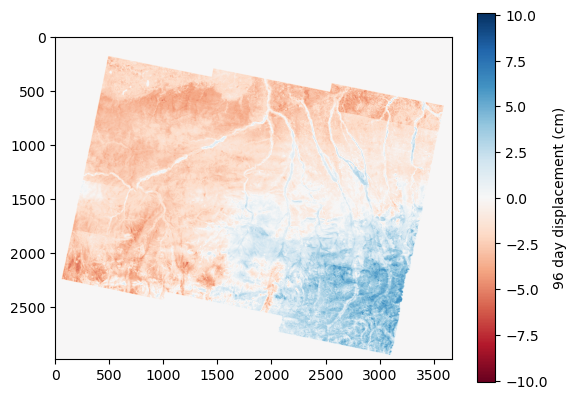

In [9]:
#show displacements at end of the timeseries
if 'timeseries_filename' not in locals():
    timeseries_filename = 'timeseries.h5'

with h5py.File(work_dir/timeseries_filename, 'r') as f:
    dispmap = np.array(f['timeseries'][-1])*100

vmax = np.nanmax(np.abs(dispmap))
plt.figure()
plt.imshow(dispmap,vmin=-vmax,vmax=vmax,cmap='RdBu')
plt.colorbar(label='96 day displacement (cm)')

<a id='permafrost_insar_structure'></a>
##  4.1 Use structure functions to identify pixel pairs

We sample a large set of pixel pairs to compare relative displacements with. We use a water mask from the Hyp3 processing to mask out locations to not use. Information about how that water mask is developed can [be found here](https://storymaps.arcgis.com/stories/485916be1b1d46889aa436794b5633cb).

Text(0, 0.5, 'Frequency')

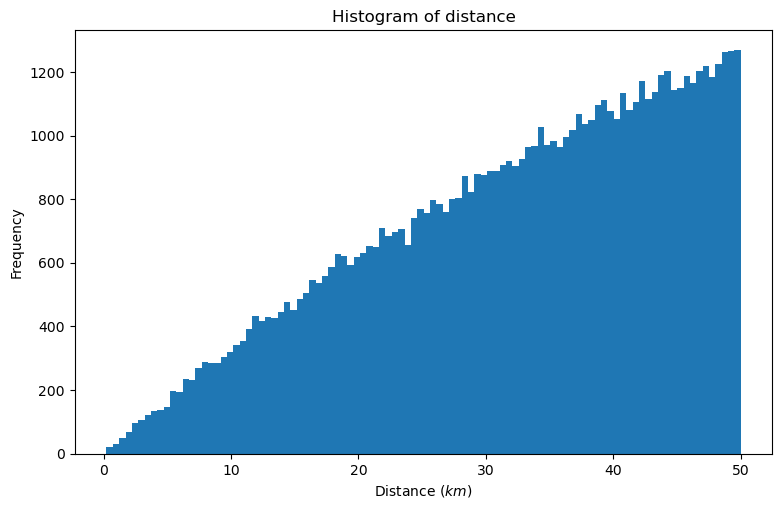

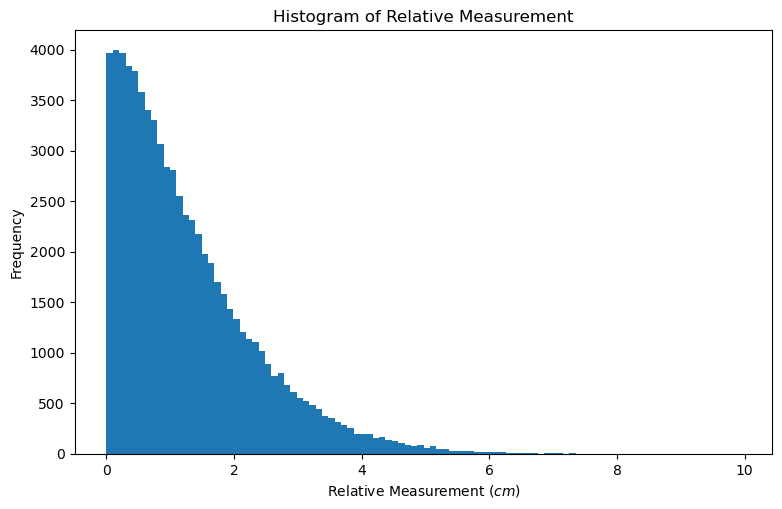

In [14]:
__,atrib = readfile.read(work_dir/timeseries_filename)

X0,Y0 = load_geo_utm(atrib)
X0_2d,Y0_2d = np.meshgrid(X0,Y0)

M2dist = []; rel_measure = []

tsmap = dispmap
tsmap[tsmap==0]=np.nan

wmask = pu.get_watermask(hyp3_dir)
tsmap[wmask==0]=np.nan

#deramping will remove linear spatial trends in the displacement data, currently disabled
dist_i, rel_measure_i = samp_pair(X0_2d,Y0_2d,tsmap,num_samples=1000000,deramp=False)

M2dist.append(dist_i)             #distance of pair, in m
rel_measure.append(rel_measure_i) #relative displacement of pair, in cm 
    
M2dist,rel_measure = np.array(M2dist),np.array(rel_measure)

#use only pixel pairs within 50 km
rel_measure = rel_measure[M2dist<=50e3]
M2dist=M2dist[M2dist<=50e3]

M2km = [i/1e3 for i in M2dist]  #convert distance to km
rmcm = [i for i in rel_measure] #relative measure in cm

fig, ax = plt.subplots(figsize=[9, 5.5])
img1 = ax.hist(M2km, bins=100)
ax.set_title(f"Histogram of distance")
ax.set_xlabel(r'Distance ($km$)')
ax.set_ylabel('Frequency')

fig, ax = plt.subplots(figsize=[9, 5.5])
img1 = ax.hist(rmcm, bins=100)
ax.set_title(f"Histogram of Relative Measurement")
ax.set_xlabel(r'Relative Measurement ($cm$)')
ax.set_ylabel('Frequency')

<a id='permafrost_insar_evaluate'></a>
## 4.2 Compare pair displacements to requirement

In [11]:
#Here we define a function to help with the plotting in this section.

from matplotlib import cm
from matplotlib.colors import Normalize 
from scipy.interpolate import interpn

def arraypercentile(arr,p,axis=0,bounds=None):
    """for a given array arr, returns the index of where that percentile
    is reached."""
    
    if axis==0:
        arr= np.transpose(arr)
    
    ilen,jlen = np.shape(arr)

    if bounds==None:
        bounds=[0,ilen]
    boundlen = bounds[1]-bounds[0]
    targets = np.sum(arr,axis=0)*p
    perindex = np.zeros(jlen)
    pervals = np.zeros(jlen)
    
    for j in range(jlen):
        currsum = 0
        curri = -1
        jtarget = targets[j]
        while currsum<=jtarget:
            oldsum=currsum
            curri += 1
            currsum += arr[curri,j]

        overfrac = (jtarget-oldsum)/(currsum-oldsum)
        perindex[j] = (curri-1)+overfrac
        pervals[j]=bounds[0]+perindex[j]/ilen*(boundlen)
    return pervals

Requirement success rate: 88.5%


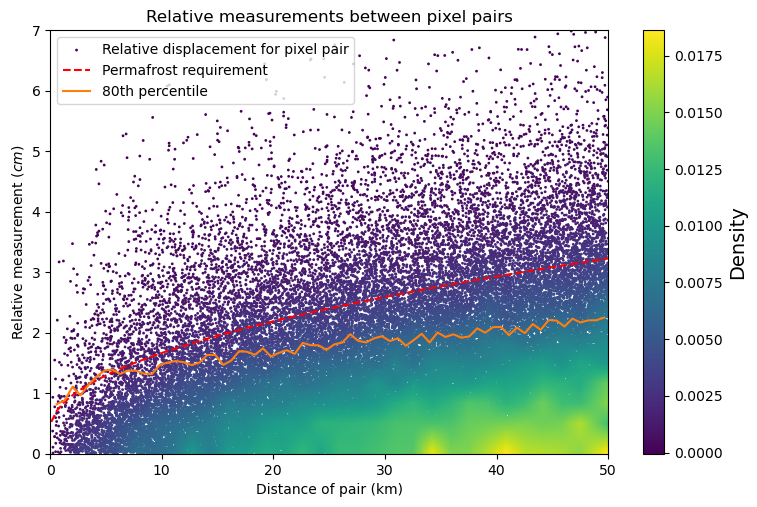

In [18]:
#requirements in mm (needs M2dist in km):
rel_req = 4*(1+np.sqrt(M2dist/1e3)) / 10 #req in cm

n_samples = len(M2dist)
n_met = np.sum(rel_measure<=rel_req)

print(f'Requirement success rate: {n_met/n_samples*100:.1f}%')
      
# Color plotted points by density. This is what interpn from scipy is required for.
# Code inspired by https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib/53865762#53865762
x,y = np.array(M2km), np.array(rmcm)
nbins = 30
data , x_e, y_e = np.histogram2d(x,y, bins=(nbins,nbins), density = True )
z = interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T,
                method = "linear",fill_value=None, bounds_error = False)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

fig, ax = plt.subplots(figsize=[9, 5.5])
ax.scatter( x, y, c=z,s=1,label='Relative displacement for pixel pair')

ax.set_xlim(0,50)
ax.set_ylim(0,7)
norm = Normalize(vmin = np.min(z), vmax = np.max(z))
cbar = fig.colorbar(cm.ScalarMappable(norm = norm), ax=ax)
cbar.ax.set_ylabel('Density',fontsize=14)
ax.plot(dist_th, acpt_error_cm, '--', color='r',label='Permafrost requirement')

#go through data again to make 80th percentile line
nbins = 70
data , x_e, y_e = np.histogram2d(x,y, bins=(nbins,nbins), density = True )
pervec = arraypercentile(data,.8,bounds=[y_e[0],y_e[-1]])
xmid = [.5*(x_e[i]+x_e[i+1]) for i in range(len(x_e)-1)]
ax.plot(xmid,pervec,color='C01',label='80th percentile')

ax.set_title(f"Relative measurements between pixel pairs")
ax.set_ylabel(r'Relative measurement ($cm$)')
ax.set_xlabel('Distance of pair (km)')

plt.legend(loc='upper left')

out_fig = os.path.abspath('permafrost_insar_vs_distance.png')
fig.savefig(out_fig, bbox_inches='tight', transparent=True, dpi=300)

<a id='permafrost_field_validate'></a>
# 5. Validation method B: Comparison to ground truth displacements

We can compare the Interferometric displacements to the measured displacements at the field sites. The locations of the field sites are as follows (XY values in UTM, EPSG 32605):

Happy Valley (HV): x=664946, y=7677215</br>
Happy Valley East (HVE): x=665175, y=7677290</br>
Ice Cut (IC): x=666290, y=7664601</br>
Slope Mountain (SM): x=664156, y=7629999</br>

In [19]:
pointnames = ['HV','HVE','IC','SM']
pointlocs = [[1114,3285],[1113,3288],[1272,3302],[1705,3275]]
pointlocsxy = [[664946,7677215],[665175,7677290],[666290,7664601],[664156,7629999]]
pointsubsetlocs = [[119, 287], [118, 290], [277, 304], [710, 277]]

<a id='permafrost_field_data'></a>
## 5.1 Load field data

Field observations of summer subsidence were taken for several areas of interest on the North Slope of Alaska, along the Dalton Highway. The ground in this area is snow-free for approximately three months each summer, usually from late May to late August. Measurements from leveling (surveying) and GNSS were taken at the beginning and end of this summer time period. Each field area of interest has 153 sampled points over a 100 m square on the ground.

The end result of these observations are direct measurements of the surface subsidence which can be compared with the satellite-InSAR derived surface displacement product. See the accompanying notebook [Permafrost_fielddata](./Permafrost_fielddata.ipynb) for details. That notebook produces a small file called ```field_results.csv```, which is an input for this validation.

We create an array for the relative displacement of each field site relative to each other site.

In [20]:
#Load in observed data
fielddata_file = work_dir/'fielddata'/'field_results.csv'

obsdata = pd.read_csv(fielddata_file) #ground truth observations
obsdisp = obsdata['rel_change'][:]
obsstd = obsdata['stdev'][:]
obsdiff = np.zeros((len(obsdisp),len(obsdisp)))
obsdiffstd = np.zeros_like(obsdiff)
fielddates = []
for i in range(len(obsdisp)):
    for j in range(len(obsdisp)):
        obsdiff[i,j] = obsdisp[i]-obsdisp[j]

        #use sum of squares to propagate error of subtracted measurements
        obsdiffstd[i,j] = np.sqrt(obsstd[i]**2+obsstd[j]**2)
    
    date1 = datetime.strptime(str(obsdata['date1'][i]),'%Y%m%d')
    date2 = datetime.strptime(str(obsdata['date2'][i]),'%Y%m%d')
    fielddates.append([date1,date2])

<a id='permafrost_field_prepare'></a>
## 5.2 Prepare InSAR for field comparison


In order to perform double differencing of InSAR displacements in a way that will be comparable to the field observations, we run the mintpy inversion several times, with the reference point set to a different field validation site each time, and also using a spline fitting function to fit the InSAR timeseries to the exact dates of the field measurements.

**Mintpy subsetting**

Below is an example of running Mintpy with a small area subset, using the same reference point.

In [21]:
subsetstr = '[7620213:7686754, 641941:679925]'
writenumpyconfig(config_file,hyp3_dir,reflalo=sites[site]['mintpy_ref_loc'],subset = subsetstr)
!smallbaselineApp.py --dir {work_dir} {config_file}


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.1, 2023-01-03
___________________________________________________________

--RUN-at-2024-03-22 23:07:57.364369--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineApp.py on steps: ['load_data', 'modify_network'

**Time series reconstruction**

The displacement time series from mintpy is reconstruted here by spline-fitting it the time series to a set of basis functions, following Zwieback et al. (2020). The basis functions represent typical summer permafrost surface subsidence patterns, due melting ice in the active layer. The spline fitting reconstruction both reduces the noise from individual acquisitions, and also allows us to identify the InSAR displacement for arbitrary dates within the period.


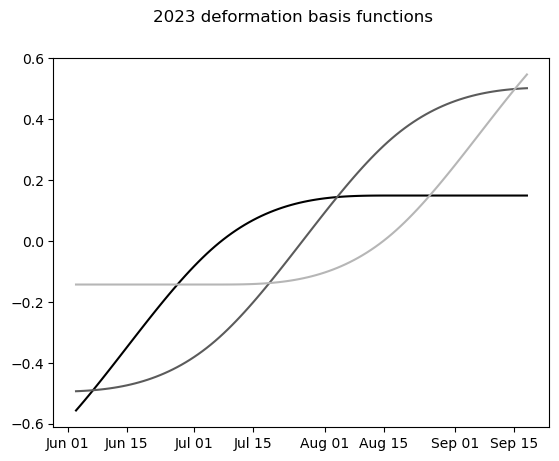

In [22]:
ts = pu.Timeseries.from_file(fn = work_dir/timeseries_filename)
sm = pu.SplineModel(dates_o=ts.dates)

#perform the reconstruction
ts_rec = sm.reconstruct(timeseries=ts)

# plot basis functions
pu.plot_basis_functions(sm)

Now we will demonstrate the reconstuction at a single point.

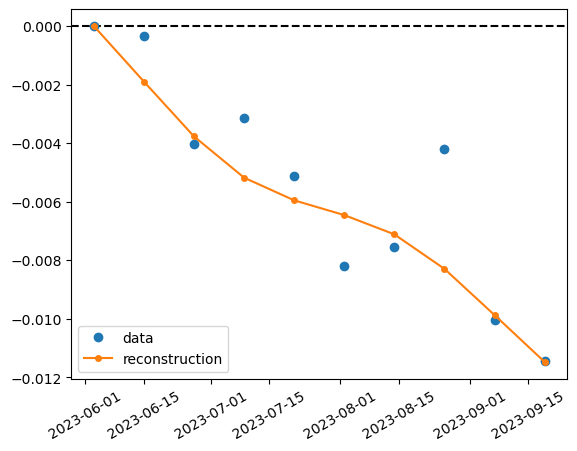

In [55]:
ipt,jpt = 400,300

plt.figure()
plt.axhline(y=0,linestyle='--',color='k')
plt.plot(ts.dates,ts.timeseries[:,ipt,jpt],'.',markersize=12,label='data')
plt.plot(ts_rec.dates,ts_rec.timeseries[:,ipt,jpt],'.-',markersize=8,label='reconstruction')
plt.xticks(rotation=30)
plt.legend()

Additionally we can show the summertime displacement across the entire region:

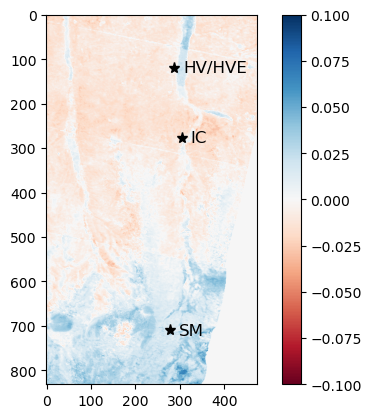

In [36]:
#The fieldsites of Happy Valley and Happy Valley East are too close
#to plot separately in this step.
labelpoints = [[119, 287], [277, 304], [710, 277]]
labelpointnames = ['HV/HVE','IC','SM']

plt.figure()
plt.imshow(ts_rec.timeseries[-1]-ts_rec.timeseries[0],vmin=-0.10,vmax=0.10,cmap='RdBu')
plt.colorbar()
for k,name in enumerate(labelpointnames):
    pt = labelpoints[k]
    plt.plot(pt[1],pt[0],'*',markersize=8,color='k')
    plt.text(pt[1]+20,pt[0]+10,name,fontsize=12)


<a id='permafrost_field_reference_point'></a>
## 5.3 Re-run Mintpy with field reference points

We run mintpy with the reference point set to one of the field sites and compare the relative displacements at other sites, which can then be compared to the relative displacments between sites from field observations. If this notebook is running in OpenScienceLab this step will take approximately 7 minutes.

['HV', 'HVE', 'IC', 'SM']



 NOW DOING: HV


___________________________________________________________

  /##      /## /##             /##     /#######
 | ###    /###|__/            | ##    | ##__  ##
 | ####  /#### /## /#######  /######  | ##  \ ## /##   /##
 | ## ##/## ##| ##| ##__  ##|_  ##_/  | #######/| ##  | ##
 | ##  ###| ##| ##| ##  \ ##  | ##    | ##____/ | ##  | ##
 | ##\  # | ##| ##| ##  | ##  | ## /##| ##      | ##  | ##
 | ## \/  | ##| ##| ##  | ##  |  ####/| ##      |  #######
 |__/     |__/|__/|__/  |__/   \___/  |__/       \____  ##
                                                 /##  | ##
                                                |  ######/
   Miami InSAR Time-series software in Python    \______/
          MintPy 1.5.1, 2023-01-03
___________________________________________________________

--RUN-at-2024-03-19 18:26:19.536265--
Current directory: /home/jovyan/NISAR_cal/work/permafrost_ouputs/NorthSlopeEastD102/2023
Run routine processing with smallbaselineAp

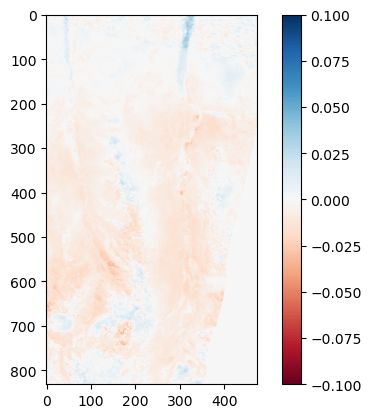

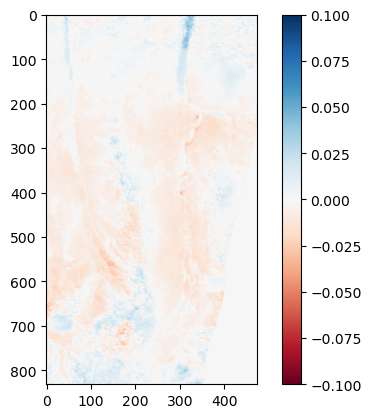

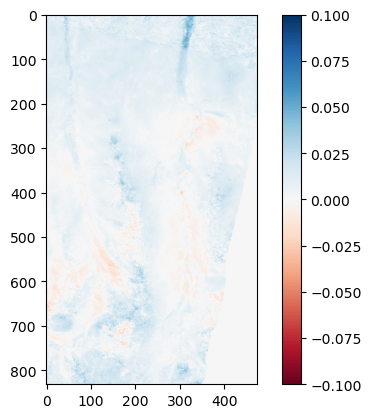

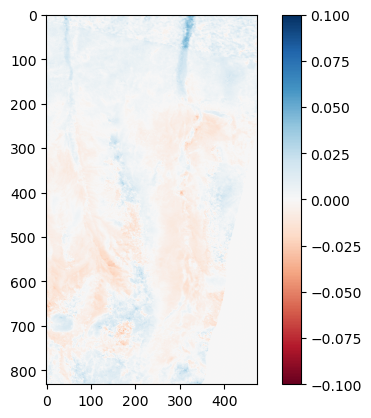

In [20]:

loclen = len(pointnames)
print(pointnames)
dispdiff = np.zeros((loclen,loclen)) #displacement difference
subsetstr = '[7620213:7686754, 641941:679925]'

for k in range(loclen):
    print(f'\n\n\n NOW DOING: {pointnames[k]}\n')
    
    #redo ref point, rerun mintpy
    refptstr = f'{pointlocsxy[k][1]}, {pointlocsxy[k][0]}'
    writenumpyconfig(config_file,hyp3_dir,reflalo = refptstr, subset = subsetstr)
    if k==0:
        !smallbaselineApp.py --dir {work_dir} {config_file}
    else:
        !smallbaselineApp.py --dir {work_dir} {config_file} --dostep reference_point
        !smallbaselineApp.py --dir {work_dir} {config_file} --dostep invert_network

    #redo spline reconstruction
    print('\n performing spline reconstruction')
    ts = pu.Timeseries.from_file(fn = work_dir/timeseries_filename)
    sm = pu.SplineModel(dates_o=ts.dates)
    ts_rec = sm.reconstruct(timeseries=ts,dates_r=fielddates[k])
    
    for l in range(loclen):
        ipt,jpt = pointsubsetlocs[l]
        print(f'{ipt}, {jpt}')
        dispdiff[k,l] = ts_rec.timeseries[1,ipt,jpt] - ts_rec.timeseries[0,ipt,jpt]
        # dispdiff[k,l]=refdisp - (ts_rec.timeseries[1,ipt,jpt]-ts_rec.timeseries[0,ipt,jpt])
        
    plt.figure()
    plt.imshow(ts_rec.timeseries[1]-ts_rec.timeseries[0],cmap='RdBu',vmin=-0.1,vmax=0.1)
    plt.colorbar()
    
print(dispdiff)

<a id='permafrost_field_evaluate'></a> 
## 5.4 Evaluate displacements to NISAR permafrost requirement

Step 1: identify distances between field sites.

In [40]:
#Identify distances
__,atrib = readfile.read(work_dir/timeseries_filename) #note data could be large, and will soon be replaced with data
xst = float(atrib['X_STEP'])
yst = float(atrib['Y_STEP'])

loclen = len(pointnames)
dist = np.zeros((loclen,loclen)) #distance, will be in km
for k in range(loclen):
    iref,jref = pointlocs[k]
    for l in range(loclen):
        ipt,jpt = pointlocs[l]
        dist[k,l] = np.sqrt(((iref-ipt)*yst)**2+((jref-jpt)*xst)**2)/1e3


Step 2: compare the relative displacements to the requirement.

In [ ]:
insvec = dispdiff.flatten()*100 #make sure in cm
obsvec = obsdiff.flatten()*100  #make sure in cm
ddfvec = np.abs(insvec-obsvec)  #absolute difference in cm
stdvec = obsdiffstd.flatten()*100 #standard deviation of observations in cm
distvec = dist.flatten() #make sure in km
reqvec = 4*(1+np.sqrt(distvec))/10  #requirement in cm

locvec = []
for i in range(4):
    cpoint = pointnames[i]
    for j in range(4):
        locvec.append(f'{cpoint}_{pointnames[j]}')
locvec = np.array(locvec)

succvec = np.array(ddfvec <= reqvec)
maskvec = np.zeros_like(succvec)
maskvec[np.isnan(ddfvec)]=True
maskvec[ddfvec==0]=True

abs_ddiff_disp = ddfvec
abs_ddiff_disp[maskvec]=np.nan

req_met_rate = np.sum(succvec[~maskvec])/np.sum(~maskvec)
req_within_error = np.array(ddfvec-stdvec <= reqvec)
req_within_error_rate = np.sum(req_within_error[~maskvec])/np.sum(~maskvec)

Finally we plot this.

In [ ]:
print(f"Percent of double differences which meet the requirement: {req_met_rate*100:.1f}%")
print(f"Percent of double differences within margin of error of requirement: {req_within_error_rate*100:.1f}%")

dist_th = np.linspace(0.1,50,100)  # distances for evaluation
acpt_error = 4*(1+np.sqrt(dist_th))  # permafrost threshold in mm
acpt_error_cm = acpt_error/10.
# abs_ddiff_disp = [abs(i) for i in diff_res_list1]
start_date = fielddates[0][0]
end_date = fielddates[0][1]
# print(len(dist))

fig, ax = plt.subplots(figsize=(11,7))
plt.scatter(dist,abs_ddiff_disp,label='|$D_{obs} - D_{InSAR}|$ for pair')
plt.plot(dist_th, acpt_error_cm, 'r',label='Permafrost requirement')
plt.ylim(0,10)
plt.xlim(0,50)
plt.legend(loc='upper left')
plt.title(f"Double-Difference Residuals \n Date range {start_date.strftime('%Y-%m-%d')} to {end_date.strftime('%Y-%m-%d')} \n InSAR and surveying/GNSS simple subtraction displacement")
plt.xlabel("Distance (km)")
plt.ylabel("Amplitude of Double-Differenced Displacement Residual (cm)")
plt.errorbar(distvec,abs_ddiff_disp,yerr=stdvec,ls='none',capsize=5)
plt.show()

<a id='permafrost_references'></a>
### References

Zwieback, Simon, and Franz J. Meyer. "Top-of-permafrost ground ice indicated by remotely sensed late-season subsidence." *The Cryosphere* 15 (2021): 2041-2055.